In [443]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Get the data

In [444]:
response = requests.get('https://www.quandl.com/api/v3/datasets/FSE/BDT_X')
response_json = response.json()
df = pd.DataFrame(response_json['dataset']['data'], columns = response_json['dataset']['column_names'])
df_bdtx = df[['Date','Open','High','Low','Close']]
df_bdtx.fillna(0,inplace=True)

In [445]:
df_bdtx['Datetime'] = pd.to_datetime(df_bdtx['Date'])
df_bdtx.set_index('Datetime',inplace=True)
df_bdtx.drop('Date',axis=1,inplace=True)

In [446]:
df_bdtx.head()

,Open,High,Low,Close
Datetime,,,,
2020-12-01,38.00,38.00,38.00,38.00
2020-11-30,36.60,38.00,36.60,38.00
2020-11-27,35.65,37.20,35.65,36.50
2020-11-26,38.75,38.75,35.70,35.70
2020-11-25,36.60,39.05,36.60,38.75


In [447]:
df_bdtx.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [448]:
df_bdtx['MA90']= df_bdtx['Close'].rolling(90).mean()
df_bdtx['MA30']= df_bdtx['Close'].rolling(30).mean()
df_bdtx['MA7']= df_bdtx['Close'].rolling(7).mean()
df_bdtx.dropna(inplace=True)

In [449]:
df_bdtx.head()

,Open,High,Low,Close,MA90,MA30,MA7
Datetime,,,,,,,
2020-07-28,33.15,33.15,32.35,32.40,33.002222,33.231667,31.900000
2020-07-27,32.85,33.15,32.20,32.90,32.945556,33.186667,31.892857
2020-07-24,33.40,33.50,32.95,33.20,32.892222,33.146667,32.028571
2020-07-23,33.30,34.00,32.90,33.70,32.861111,33.123333,32.235714
2020-07-22,33.55,33.60,32.70,32.95,32.830556,33.080000,32.457143


### MA(90/30/7) + Monthly avg plotting

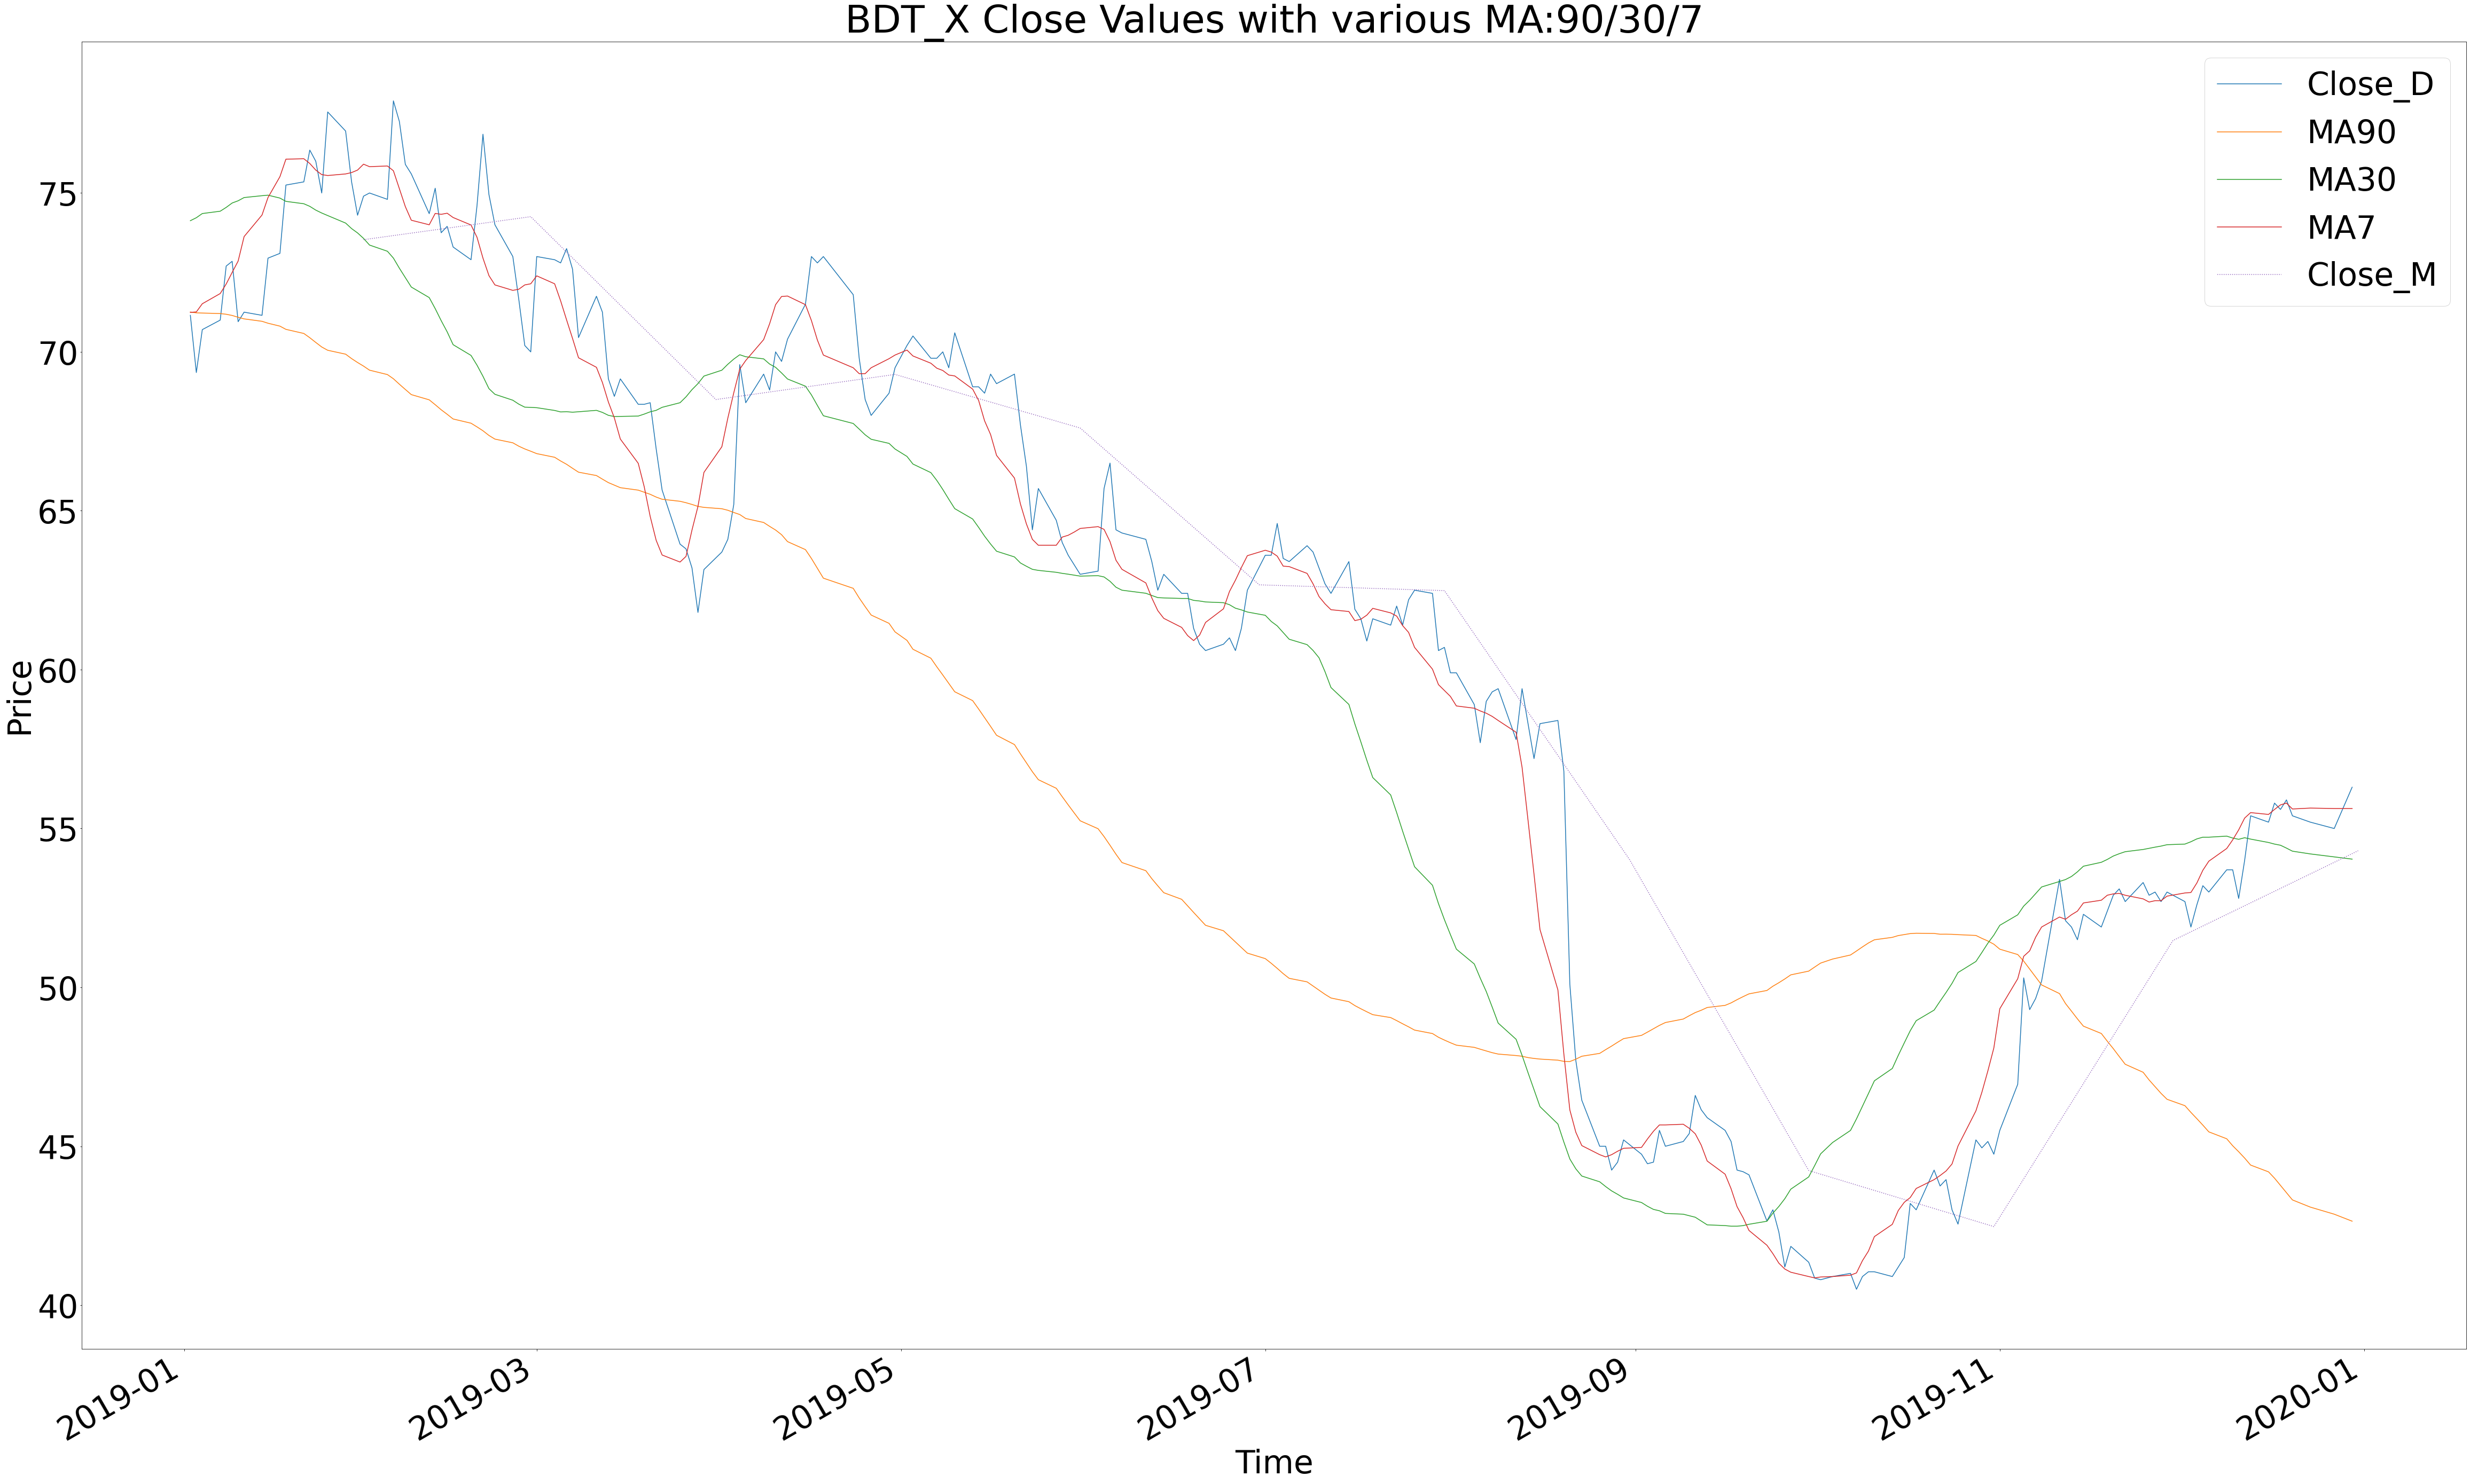

In [451]:
plt.figure(figsize=(80, 50))
plt.rcParams.update({'font.size': 60})
df_bdtx.Close.loc['2020-01-01':'2019-01-01'].plot()
df_bdtx.MA90.loc['2020-01-01':'2019-01-01'].plot()
df_bdtx.MA30.loc['2020-01-01':'2019-01-01'].plot()
df_bdtx.MA7.loc['2020-01-01':'2019-01-01'].plot()
df_bdtx.Close.loc['2020-01-01':'2019-01-01'].resample('M').mean().plot(style=':')
plt.title('BDT_X Close Values with various MA:90/30/7')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(['Close_D', 'MA90', 'MA30','MA7','Close_M'],
           loc='upper right');
plt.show()


##### Due to the following error, I had to reduced the image
##### ValueError: Image size of 748818558x3084511 pixels is too large. It must be less than 2^16 in each direction.
### Annotations

In [452]:
df_bdtx['PriceDiff'] =-(df_bdtx['Close'].shift(-1) - df_bdtx['Close'])
df_bdtx['u_dir'] = [1 if df_bdtx['PriceDiff'].loc[ei] > 0 else 0 for ei in df_bdtx.index ]
df_bdtx['d_dir'] = [1 if df_bdtx['PriceDiff'].loc[ei] < 0 else 0 for ei in df_bdtx.index ]
df_bdtx.sort_values(by=['Datetime'],inplace=True)
df_bdtx['five_trend_u'] = df_bdtx.u_dir * (df_bdtx.groupby((df_bdtx.u_dir == 0).cumsum()).cumcount())
df_bdtx['four_trend_d'] = df_bdtx.d_dir * (df_bdtx.groupby((df_bdtx.d_dir == 0).cumsum()).cumcount())
df_bdtx.tail()

,Open,High,Low,Close,MA90,MA30,MA7,PriceDiff,u_dir,d_dir,five_trend_u,four_trend_d
Datetime,,,,,,,,,,,,
2020-07-22,33.55,33.60,32.70,32.95,32.830556,33.080000,32.457143,-0.70,0,1,0,1
2020-07-23,33.30,34.00,32.90,33.70,32.861111,33.123333,32.235714,0.75,1,0,1,0
2020-07-24,33.40,33.50,32.95,33.20,32.892222,33.146667,32.028571,-0.50,0,1,0,1
2020-07-27,32.85,33.15,32.20,32.90,32.945556,33.186667,31.892857,-0.30,0,1,0,2
2020-07-28,33.15,33.15,32.35,32.40,33.002222,33.231667,31.900000,-0.50,0,1,0,3


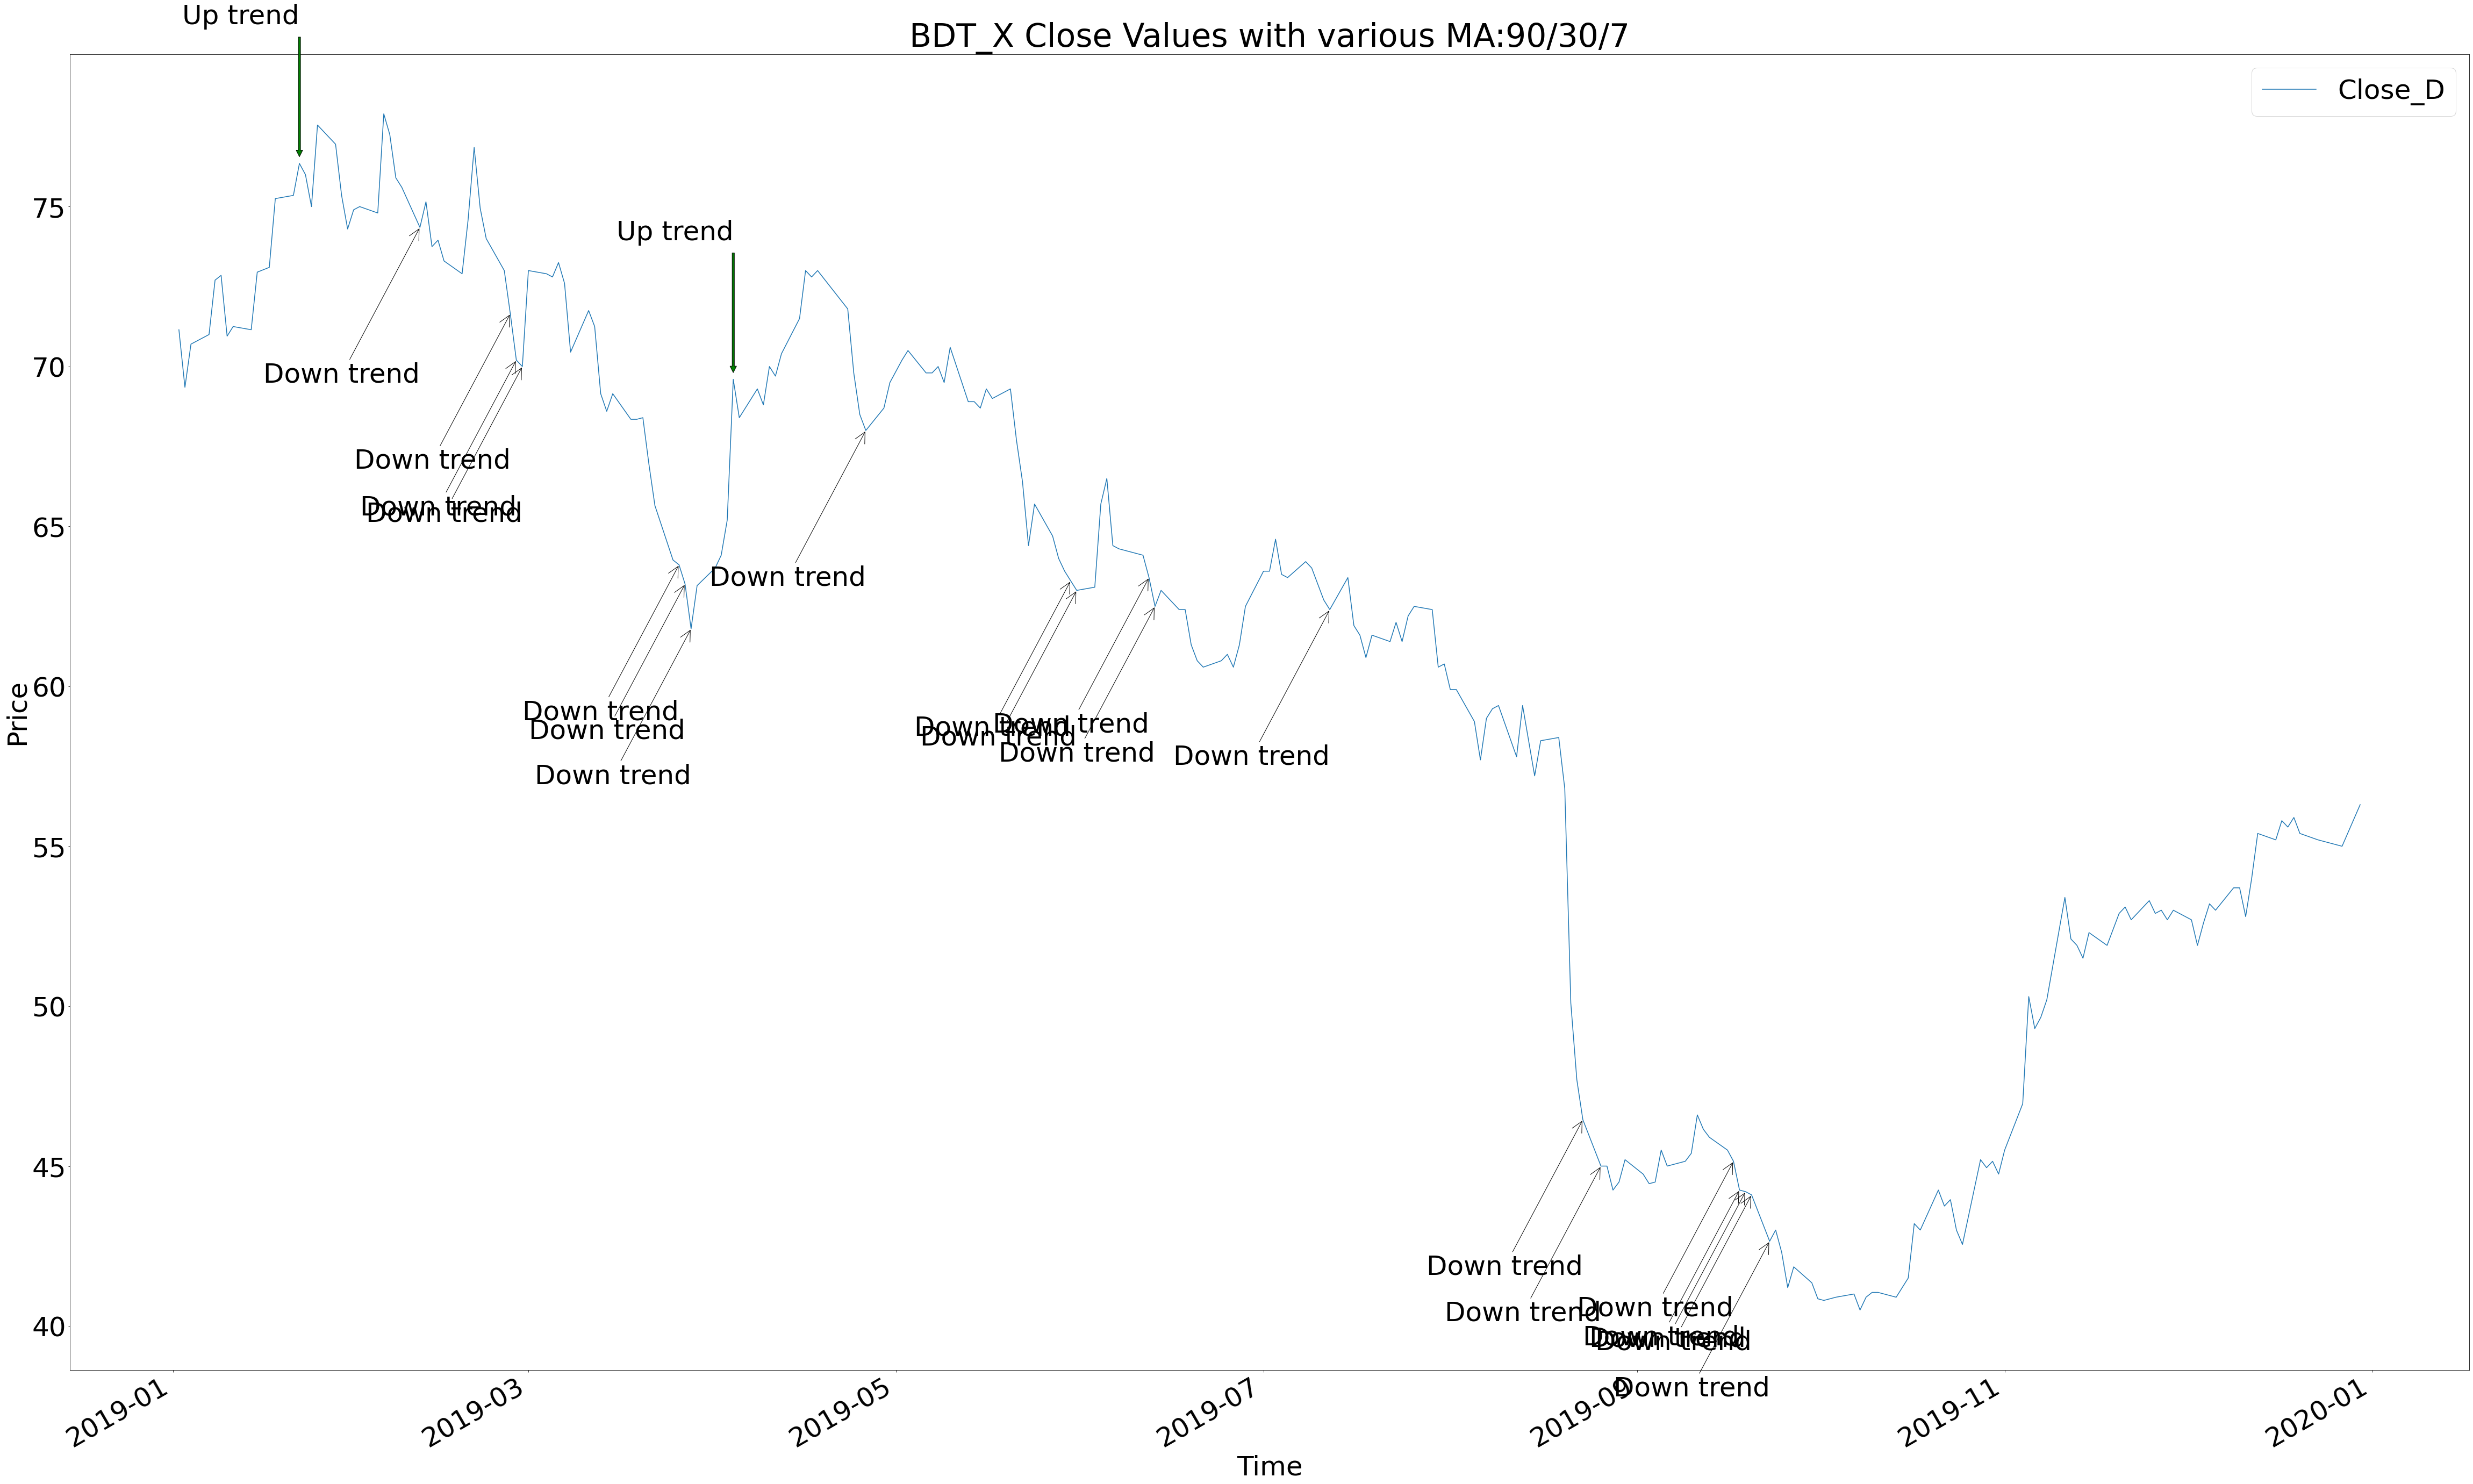

In [453]:
df = df_bdtx.loc['2019-01-01':'2020-01-01']
plt.figure(figsize=(80, 50))
plt.rcParams.update({'font.size': 50})
df.Close.plot()
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(['Close_D'],
           loc='upper right');
plt.title('BDT_X Close Values with various MA:90/30/7')

arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.09)

for index in df.index:
    if df.five_trend_u[index] >= 5:
        plt.annotate(
                    text = "Up trend",
                    xy=(index,df.Close[index]), xytext=(index,df.Close[index]+5),
                        arrowprops = dict(facecolor='green', shrink=0.05),
                                     horizontalalignment='right', verticalalignment='top',)
    if df.four_trend_d[index] >= 4:
        plt.annotate(
                    text = "Down trend",
                    xy=(index,df.Close[index]), xytext=(index,df.Close[index]-5),
                        arrowprops = dict(arrowstyle = "->", facecolor='red'),
                                     horizontalalignment='right', verticalalignment='bottom',)


#### Regression

In [454]:
import seaborn as sns
df_bdtx.reset_index(inplace=True)

<AxesSubplot:ylabel='MA90'>

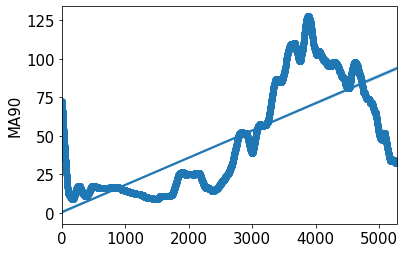

In [455]:
plt.rcParams.update({'font.size': 15})
sns.regplot(df_bdtx.index, df_bdtx.MA90)

<AxesSubplot:ylabel='MA30'>

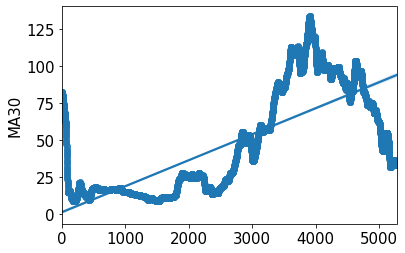

In [456]:
sns.regplot(df_bdtx.index, df_bdtx.MA30)

<AxesSubplot:ylabel='MA7'>

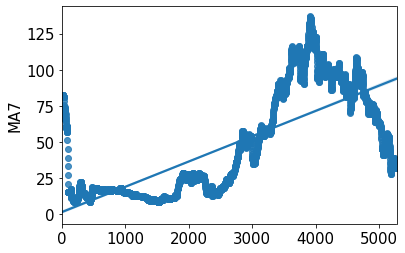

In [457]:
sns.regplot(df_bdtx.index, df_bdtx.MA7)

In [458]:
%pwd

'C:\\Users\\berge\\OneDrive\\שולחן העבודה\\מסמכים_עבודה\\Machine_Learning\\Algo_Trading with ML'